In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.postprocess import dynamic_range_nms
from utils.set_seed import seed_base

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ensemble"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ensemble']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-03 05:50:51.141283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-03 05:50:51.584240: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-03 05:50:52.882132: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_084


In [2]:
oof_xgb = pd.read_csv(f'/kaggle/output/{CFG["xgb_model"]["execution"]["best_exp_id"]}/oof.csv')
oof_xgb.head()

,series_id,step,score,event
0,038441c925bb,299,-0.036580,wakeup
1,038441c925bb,299,0.001942,onset
2,038441c925bb,323,-0.052111,wakeup
3,038441c925bb,323,0.011660,onset
4,038441c925bb,347,-0.021590,wakeup


In [3]:
oof_lgb = pd.read_csv(f'/kaggle/output/{CFG["lgb_model"]["execution"]["best_exp_id"]}/oof.csv')
oof_lgb.head()

,series_id,step,score,event
0,038441c925bb,299,-0.017086,wakeup
1,038441c925bb,299,0.008893,onset
2,038441c925bb,323,-0.020638,wakeup
3,038441c925bb,323,0.008999,onset
4,038441c925bb,347,0.004329,wakeup


In [4]:
oof_gru = pd.read_parquet(f'/kaggle/output/{CFG["patch_transformer_gru"]["execution"]["best_exp_id"]}/oof.parquet')
oof_gru.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.003191,0.000881
1,05e1944c3818,18,0.002243,0.000650
2,05e1944c3818,30,0.001784,0.000537
3,05e1944c3818,42,0.001665,0.000468
4,05e1944c3818,54,0.001548,0.000423


In [5]:
dfs = []
for seires_id, df in tqdm(oof_gru.groupby("series_id")):
    df_xgb = oof_xgb[oof_xgb["series_id"]==seires_id]
    df_lgb = oof_lgb[oof_lgb["series_id"]==seires_id]
    max_step = max(df["step"].max(), df_xgb["step"].max(), df_lgb["step"].max())
    base = pd.DataFrame({"series_id": [seires_id]*max_step, "step": range(max_step)})

    # gru
    df = base.merge(df, on=["series_id", "step"], how="left")
    df["onset_oof_gru"] = df["onset_oof"].interpolate(method="linear", direction="both").fillna(0)
    df["wakeup_oof_gru"] = df["wakeup_oof"].interpolate(method="linear", direction="both").fillna(0)

    # xgb
    xgb_wakeup = df_xgb[df_xgb["event"]=="wakeup"]
    df["wakeup_oof_xgb"] = df["step"].map(xgb_wakeup.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    xgb_onset = df_xgb[df_xgb["event"]=="onset"]
    df["onset_oof_xgb"] = df["step"].map(xgb_onset.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    # lgb
    lgb_wakeup = df_lgb[df_lgb["event"]=="wakeup"]
    df["wakeup_oof_lgb"] = df["step"].map(lgb_wakeup.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)
    lgb_onset = df_lgb[df_lgb["event"]=="onset"]
    df["onset_oof_lgb"] = df["step"].map(lgb_onset.set_index("step")["score"]).interpolate(method="linear", direction="both", limit=12*10).fillna(0)

    df["wakeup_oof"] = df["wakeup_oof_gru"] * 0.6 + df["wakeup_oof_xgb"] * 0.2 + df["wakeup_oof_lgb"] * 0.2
    df["onset_oof"] = df["onset_oof_gru"] * 0.6 + df["onset_oof_xgb"] * 0.2 + df["onset_oof_lgb"] * 0.2
    df = df[["series_id", "step", "wakeup_oof", "onset_oof"]].reset_index(drop=True)
    dfs.append(df)
oof_df = pd.concat(dfs)
del dfs
gc.collect()

100%|██████████| 277/277 [02:31<00:00,  1.83it/s]


0

16188991

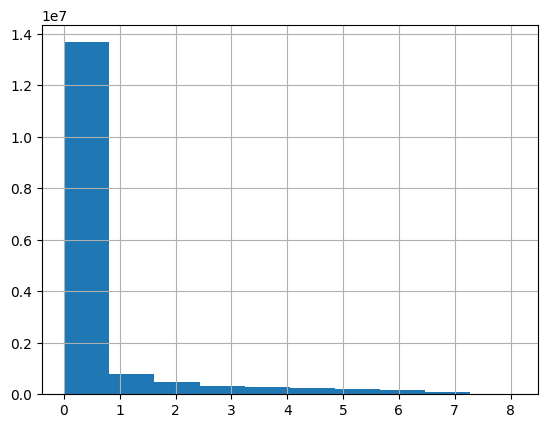

In [6]:
dfs = []
df = oof_df[["series_id", "step", "wakeup_oof"]]
df = df[df["wakeup_oof"] > 0.005]
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = oof_df[["series_id", "step", "onset_oof"]]
df = df[df["onset_oof"] > 0.005]
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs).reset_index(drop=True)
train["score"].hist()
len(train)

In [7]:
from multiprocessing import Pool

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:22<00:00, 12.47it/s]


In [8]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

score: 0.8038


event   tolerance
onset   12           0.344845
        36           0.713614
        60           0.797381
        90           0.833728
        120          0.860171
        150          0.873658
        180          0.887749
        240          0.900368
        300          0.906121
        360          0.911712
wakeup  12           0.381252
        36           0.714616
        60           0.794178
        90           0.827378
        120          0.855146
        150          0.867879
        180          0.882122
        240          0.897396
        300          0.908846
        360          0.917754
dtype: float64